<a href="https://colab.research.google.com/github/matsu641/DL-practice/blob/main/lecture07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第7回講義 演習

本演習ではPyTorchを使用し，基本的な回帰結合型ニューラルネット(RNN)と，その一種である長短期記憶(LSTM)を実装し，文章の分類タスクを解いていきます．

[IMDb (Internet Movie Database)](https://huggingface.co/datasets/stanfordnlp/imdb) と呼ばれるデータセットには，映画のレビュー文とその評価についてpositiveかnegativeか記録されています．

<div style="text-align: center;">【データセットのイメージ】</div>

| レビュー | 評価 |
|:--------:|:-------------:|
|Where's Michael Caine when you need him? I've ...|0|
|To experience Head you really need to understa...|1|

0 = negative, 1 = positive

そこで各レビュー文を入力として，その評価positive/negativeの二値分類をRNNで行ってみましょう．

## 目次

 [【課題】RNNと派生モデルの実装と学習](#scrollTo=kwLF7moq_PCZ&line=1&uniqifier=1)
1. [データセットの読み込み](#scrollTo=zEltPNkLuLz6)
2. [訓練実行(trainer)関数の定義](#scrollTo=G-laa4YqQRji)
1. Recurrent Neural Network (RNN) によるIMDbのsentiment analysis

 3.1. [Embedding層](#scrollTo=Urh6GUOQKBzE)  

 3.2. [RNN](#scrollTo=ZNPaK9ExKBzI)  

 3.3. [分類器](#scrollTo=2O0bZWqVOVk0)

 3.4. [学習](#scrollTo=emiO4f5rCklA)

 3.5. [torch.nn.RNN, torch.nn.Embeddingを用いたネットワークの記述](#scrollTo=yCktWJ9N8QDN)

1. Long short-term memory (LSTM) によるIMDbのsentiment analysis

 4.1. [LSTM](#scrollTo=tsXtYkNEm1Bh)

 4.2. [分類器](#scrollTo=IfHaLvJJWHeI)

 4.3. [学習](#scrollTo=qR2iKUy7yA3R)

 4.4. [torch.nn.LSTMを用いたネットワークの記述](#scrollTo=thf8W0lywagD)

5. Bidirectional LSTM

 5.1. [BidirectionalLSTM](#scrollTo=L9ZNn5gTP2yH)

 5.2. [学習](#scrollTo=1xbAI25fQA2E)

1. 【補足】[Gradient Clippingによる長系列への対処](#scrollTo=ExuiSiTo2k3m)

In [ ]:
!pip install portalocker
!pip install datasets

import random
import numpy as np
import string
import re
import string
from collections import Counter
from typing import List
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
from datasets import load_dataset
import nltk
from nltk.probability import FreqDist

nltk.download('punkt_tab')
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 【課題】RNNと派生モデルの実装と学習

## 1.データセットの読み込み

自然言語処理において，データとなる文をそのままネットワークに入力することは出来ないので，適切な前処理をする必要があります．

前処理の手順（英文の場合）は大まかに，
- 単語ごとに区切る
- 各単語にIDを割り振る

という手順で行われ，この手順を経ることで，元々の文は整数列に変換され，ネットワークに入力することが可能となります．

また，本演習では各単語にIDを割り振る処理に`NLTK`と呼ばれるライブラリを用いています．詳しく知りたい方は，[公式ドキュメント](https://www.nltk.org/api/nltk.html)を参照してください．

In [ ]:
# torch.log(0)によるnanを防ぐための関数
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

In [ ]:
# IMDBデータセットのダウンロード
# トークンを要求された場合でも、データセットのダウンロードにはHFトークンは不要なため、キャンセルをクリック
print("Loading IMDB dataset...")
dataset = load_dataset("stanfordnlp/imdb")
# データの分割
train_data, valid_data = random_split(
    dataset['train'], [20000, 5000],
    )
test_data = dataset['test']

[nltk.probability.FreqDist](https://www.nltk.org/api/nltk.probability.html#nltk.probability.FreqDist)で訓練データの文章内の単語を数え上げ，語彙リスト（`FreqDist`オブジェクト）を作っていきます．

引数`specials`で特別なトークンを指定しています．
- `<unk>`: Unknown. 出てくる頻度が少なすぎる単語などを未分類としておきます．
- `<PAD>`: 短い文章はこのトークンで埋めることで，長い文章に長さを合わせます．
- `<BOS>`: Begin of sentence.
- `<EOS>`: End of sentence.

In [ ]:
# 単語をスペースで区切り，!"#$%&といった記号を除去する，すべて小文字化する，などの処理
def tokenize(text):
    # 1. 小文字化
    text = text.lower()

    # 2. 記号を除去 (string.punctuation)
    text = ''.join([char for char in text if char not in string.punctuation])

    # 3. トークン化 (単語ごとに分割)
    tokens = text.split()
    return tokens

In [ ]:
# 単語の頻度を記録するためのFreqDistオブジェクトを作成
counter = FreqDist()
for i in range(len(train_data)):
    processed = tokenize(train_data[i]["text"])
    # トークン化した単語リストをFreqDistに追加して頻度を更新
    counter.update(processed)

print(f"単語数: {len(counter)}")

In [ ]:
# <unk>をデフォルトに設定し，min_freq回以上出てこない単語は<unk>にする
# min_freqとspecialsの適用
min_freq = 25
specials = ['<unk>', '<PAD>', '<BOS>', '<EOS>']

vocab = specials + [word for word, freq in counter.items() if freq >= min_freq]
vocab_dict = {word: i for i, word in enumerate(vocab)}
word_num = len(vocab_dict)

print(f"単語種数: {word_num}")
print(list(vocab_dict))

`text_transform()`を`collate_batch()`から呼び，単語のリストを辞書内インデックスのリストに変換します．

In [ ]:
def text_transform(_text, max_length=256):
    # tokenがvocab_dictに無い場合、0=<unk>を代入, <BOS>と<EOS>の分 -2
    text = [vocab_dict.get(token, 0) for token in tokenize(_text)][:max_length - 2]
    text = [vocab_dict['<BOS>']] + text + [vocab_dict['<EOS>']]
    return text, len(text)

def collate_batch(batch):
   label_list, text_list, len_seq_list = [], [], []

   for data_point  in list(batch):
      _text = data_point.get('text')
      _label = data_point.get('label')
      label_list.append(_label)

      processed_text, len_seq = text_transform(_text)
      text_list.append(torch.tensor(processed_text))
      len_seq_list.append(len_seq)

   return torch.tensor(label_list), pad_sequence(text_list, padding_value=1).T, torch.tensor(len_seq_list)

上で定義した`collate_batch()`を`DataLoader`に渡すことで，バッチに対してその処理を適用することができます．

In [ ]:
batch_size = 128

train_dataloader = DataLoader(
   list(train_data),
   batch_size=batch_size,
   shuffle=True,
   collate_fn=collate_batch
)
valid_dataloader = DataLoader(
   list(valid_data),
   batch_size=batch_size,
   shuffle=False,
   collate_fn=collate_batch
)

## 2.訓練実行(trainer)関数の定義

以降定義するすべてのモデルについて訓練ループは同じなので，ここで関数として実装してしまいます．

In [ ]:
# NOTE: dataloaderはグローバルスコープ
def train(net, optimizer, n_epochs,):
    for epoch in range(n_epochs):
        losses_train = []
        losses_valid = []

        net.train()
        n_train = 0
        acc_train = 0
        for label, line, len_seq in train_dataloader:
            net.zero_grad()  # 勾配の初期化

            t = label.to(device) # テンソルをGPUに移動
            x = line.to(device) # ( batch, time )
            len_seq.to(device)

            h = net(x, torch.max(len_seq), len_seq)
            y = torch.sigmoid(h).squeeze()

            loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))  # WRITE ME

            loss.backward()  # 誤差の逆伝播

            optimizer.step()  # パラメータの更新

            losses_train.append(loss.tolist())

            n_train += t.size()[0]

        # Valid
        t_valid = []
        y_pred = []
        net.eval()
        for label, line, len_seq in valid_dataloader:

            t = label.to(device) # テンソルをGPUに移動
            x = line.to(device)
            len_seq.to(device)

            h = net(x, torch.max(len_seq), len_seq)
            y = torch.sigmoid(h).squeeze()

            loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))  # WRITE ME

            pred = y.round().squeeze()  # 0.5以上の値を持つ要素を正ラベルと予測する

            t_valid.extend(t.tolist())
            y_pred.extend(pred.tolist())

            losses_valid.append(loss.tolist())

        print('EPOCH: {}, Train Loss: {:.3f}, Valid Loss: {:.3f}, Validation F1: {:.3f}'.format(
            epoch,
            np.mean(losses_train),
            np.mean(losses_valid),
            f1_score(t_valid, y_pred, average='macro')
        ))

## 3.Recurrent Neural Network (RNN) によるIMDbのsentiment analysis

### 3.1. Embedding層

`Embedding`層では，単語を離散的なidから連続的な数百次元のベクトルに変換(埋め込み; embedding)します．

下の`Embedding`クラスにおいて，入力$\boldsymbol{x}$は各行に文の単語のid列が入った行列で，重み$\boldsymbol{V}$は各行がそれぞれの単語idのベクトルに対応した行列です．

つまりそれぞれの行列のサイズは

- $\boldsymbol{x}$: (ミニバッチサイズ) x (ミニバッチ内の文の最大系列長)
- $\boldsymbol{V}$: (辞書の単語数) x (単語のベクトルの次元数)

です．

この$\boldsymbol{V}$から，入力$\boldsymbol{x}$のそれぞれの単語idに対して対応する単語ベクトルを取り出すことで，各単語をベクトルに変換します．

この処理によって出力されるテンソルの次元数は，(ミニバッチサイズ) x (ミニバッチ内の文の最大系列長) x (単語のベクトルの次元数)となります．

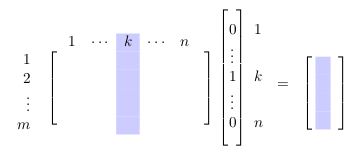)

$$m:\text{emb_dim}, \ n : \text{vocab_size}$$


In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.embedding_matrix = nn.Parameter(torch.randn((vocab_size, emb_dim),  # ガウス分布（正規分布）から乱数を生成
                                                        dtype=torch.float))

    def forward(self, x):
        return F.embedding(x, self.embedding_matrix)

### 3.2. RNN

RNNクラスでは，Embedding層で各単語がベクトルに変換されたものを入力として処理を行います．ここで入力$\boldsymbol{x}$は

- $\boldsymbol{x}$: (ミニバッチサイズ) x (ミニバッチ内の文の最大系列長) x (単語のベクトルの次元数)

となっています．

ここでは `nn.Module` を用いてRNNクラスを定義します．

In [ ]:
class RNN(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        glorot = 6 / (in_dim + hid_dim*2)
        self.W = nn.Parameter(torch.tensor(np.random.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

    def function(self, h, x):
        return torch.tanh(torch.matmul(torch.cat([h, x], dim=1), self.W) + self.b)

    def forward(self, x, len_seq_max=0, init_state=None):
        x = x.transpose(0, 1)  # 系列のバッチ処理のため、次元の順番を「系列、バッチ」の順に入れ替える
        state = init_state

        if init_state is None:  # 初期値を設定しない場合は0で初期化する
            state = torch.zeros((x[0].size()[0], self.hid_dim)).to(x.device)

        size = list(state.unsqueeze(0).size())
        size[0] = 0
        output = torch.empty(size, dtype=torch.float).to(x.device)  # 一旦空テンソルを定義して順次出力を追加する

        if len_seq_max == 0:
            len_seq_max = x.size(0)
        for i in range(len_seq_max):
            state = self.function(state, x[i])
            output = torch.cat([output, state.unsqueeze(0)])  # 出力系列の追加
        return output

### 3.3. 分類器

In [ ]:
# RNN
class SequenceTaggingNet(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.emb = Embedding(word_num, emb_dim)
        self.rnn = RNN(emb_dim, hid_dim)
        self.linear = nn.Linear(hid_dim, 1)

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)  # WRITE ME
        h = self.rnn(h, len_seq_max, init_state)
        if len_seq is not None:
            # 系列が終わった時点での出力を取る必要があるので len_seq を元に集約する
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]
        y = self.linear(h)
        return y

### 3.4. 学習

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet(word_num, emb_dim, hid_dim)
net.to(device)

optimizer = optim.Adam(net.parameters())

train(net, optimizer, n_epochs)

### 3.5. `torch.nn.RNN`, `torch.nn.Embedding` を用いたネットワークの記述

`torch.nn.Conv2d`を用いてCNN層を容易に実装することができたように，`torch.nn.RNN`を用いることで容易にRNN層を実装することができます．

`torch.nn.RNN`は，系列データ $x$ と初期状態 $h_0$ を引数として受け取り，出力系列 $y$ と最終状態 $h$ を出力します．（`y, h = self.RNN(x, h_0)`）

また，少し厄介なことに`nn.RNN`の入力の系列データは，デフォルトで次元が [系列，ミニバッチ，各要素のベクトル] の順番となっています．しかしながら，データローダーが与えるデータは [ミニバッチ，系列，各要素] の順番となっており，この順番の方が直感的であると考えられます．これを解決するため，`torch.nn.RNN`は引数`batch_first`を受け取ることができ，これを`True`にすることで入力系列を [ミニバッチ，系列，各要素] の順番で受け取ることができます．

`batch_first=True`とすると出力の順番も入れ替わるので，`transpose`を用いて [系列，ミニバッチ，各要素のベクトル] としてから`len_seq`を元に最終出力を取り出します．

さらに，`torch.nn.RNN`は引数`num_layers`を持ち，RNNを何層重ねるかを指定します．多層に重ねることもできますが，ここでは課題2の実装と揃えるため一層とします．

また，`torch.nn.Embedding`を用いることでEmbedding層も容易に実装することができます．

In [ ]:
# nn.RNN
class SequenceTaggingNet2(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.emb = nn.Embedding(word_num, emb_dim)  # nn.Embeddingの使用
        self.rnn = nn.RNN(emb_dim, hid_dim, 1, batch_first=True)  # nn.RNNの使用
        self.linear = nn.Linear(hid_dim, 1)

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)  # WRITE ME
        if len_seq_max > 0:
            h, _ = self.rnn(h[:, 0:len_seq_max, :], init_state)
        else:
            h, _ = self.rnn(h, init_state)
        h = h.transpose(0, 1)
        if len_seq is not None:
            # 系列が終わった時点での出力を取る必要があるので len_seq を元に集約する
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]

        y = self.linear(h)  # WRITE ME

        return y

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet2(word_num, emb_dim, hid_dim)
net.to(device)

optimizer = optim.Adam(net.parameters())

train(net, optimizer, n_epochs)

## 4.Long short-term memory (LSTM)

### 4.1. LSTM

実装する式は次のようになります．($\odot$は要素ごとの積)

- 入力ゲート: $\hspace{20mm}\boldsymbol{i}_t = \mathrm{\sigma} \left(\boldsymbol{W}_i \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_i\right)$
- 忘却ゲート: $\hspace{20mm}\boldsymbol{f}_t = \mathrm{\sigma} \left(\boldsymbol{W}_f \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_f\right)$  
- 出力ゲート: $\hspace{20mm}\boldsymbol{o}_t = \mathrm{\sigma} \left(\boldsymbol{W}_o \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_o\right)$  
- セル:　　　 $\hspace{20mm}\boldsymbol{c}_t = \boldsymbol{f}_t \odot \boldsymbol{c}_{t-1} + \boldsymbol{i}_t \odot \tanh \left(\boldsymbol{W}_c \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_c\right)$
- 隠れ状態: 　$\hspace{20mm}\boldsymbol{h}_t = \boldsymbol{o}_t \odot \tanh \left(\boldsymbol{c}_t \right)$

単純なRNNでは各ステップの関数の戻り値は隠れ状態のみ ($\boldsymbol{h}_t$) でしたが，LSTMではセル状態と隠れ状態の2つ ($\boldsymbol{c}_t, \boldsymbol{h}_t$) となるので注意してください．

In [ ]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        glorot = 6/(in_dim + hid_dim*2)

        self.W_i = nn.Parameter(torch.tensor(np.random.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b_i = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

        self.W_f = nn.Parameter(torch.tensor(np.random.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b_f = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

        self.W_o = nn.Parameter(torch.tensor(np.random.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b_o = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

        self.W_c = nn.Parameter(torch.tensor(np.random.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b_c = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

    def function(self, state_c, state_h, x):
        i = torch.sigmoid(torch.matmul(torch.cat([state_h, x], dim=1), self.W_i) + self.b_i)  # WRITE ME
        f = torch.sigmoid(torch.matmul(torch.cat([state_h, x], dim=1), self.W_f) + self.b_f)  # WRITE ME
        o = torch.sigmoid(torch.matmul(torch.cat([state_h, x], dim=1), self.W_o) + self.b_o)  # WRITE ME
        c = f*state_c + i*torch.tanh(torch.matmul(torch.cat([state_h, x], dim=1), self.W_c) + self.b_c)  # WRITE ME
        h = o*torch.tanh(c)  # WRITE ME
        return c, h

    def forward(self, x, len_seq_max=0, init_state_c=None, init_state_h=None):
        x = x.transpose(0, 1)  # 系列のバッチ処理のため、次元の順番を「系列、バッチ」の順に入れ替える
        state_c = init_state_c
        state_h = init_state_h
        if init_state_c is None:  # 初期値を設定しない場合は0で初期化する
            state_c = torch.zeros((x[0].size()[0], self.hid_dim)).to(x.device)
        if init_state_h is None:  # 初期値を設定しない場合は0で初期化する
            state_h = torch.zeros((x[0].size()[0], self.hid_dim)).to(x.device)

        size = list(state_h.unsqueeze(0).size())
        size[0] = 0
        output = torch.empty(size, dtype=torch.float).to(x.device)  # 一旦空テンソルを定義して順次出力を追加する

        if len_seq_max == 0:
            len_seq_max = x.size(0)
        for i in range(len_seq_max):
            state_c, state_h = self.function(state_c, state_h, x[i])
            output = torch.cat([output, state_h.unsqueeze(0)])  # 出力系列の追加
        return output

### 4.2. 分類器

In [ ]:
# LSTM
class SequenceTaggingNet3(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.emb = Embedding(word_num, emb_dim)
        self.lstm = LSTM(emb_dim, hid_dim)
        self.linear = nn.Linear(hid_dim, 1)

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)  # WRITE ME
        h = self.lstm(h, len_seq_max, init_state)  # WRITE ME
        if len_seq is not None:
            # 系列が終わった時点での出力を取る必要があるので len_seq を元に集約する
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]

        y = self.linear(h)  # WRITE ME

        return y

### 4.3. 学習

同じタスクを用いてRNNとLSTMの性能を比較します．

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 5
device = 'cuda'

net = SequenceTaggingNet3(word_num, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

train(net, optimizer, n_epochs)

### 4.4. `nn.LSTM`を用いたネットワークの記述

LSTMもRNNと同様に`nn.LSTM`を用いて実装することができます．

In [ ]:
# nn.LSTM
class SequenceTaggingNet4(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.emb = nn.Embedding(word_num, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, 1, batch_first=True)  # nn.LSTMの使用
        self.linear = nn.Linear(hid_dim, 1)

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)
        if len_seq_max > 0:
            h, _ = self.lstm(h[:, 0:len_seq_max, :], init_state)
        else:
            h, _ = self.lstm(h, init_state)
        h = h.transpose(0, 1)
        if len_seq is not None:
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]
        y = self.linear(h)

        return y

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet4(word_num, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

train(net, optimizer, n_epochs)

## 5.双方向LSTM

### 5.1. BidirectionalLSTM

双方向LSTMでは，順方向にシークエンスを処理するLSTM（`self.forward_lstm`）と逆方向にシークエンスを処理するLSTM（`self.backward_lstm`）を別々に用意し，それぞれの出力を結合したものを全結合層へ渡します．  
これによりパラメータ数は増えますが，未来方向からの文脈も考慮した予測を行うことができるようになります．

[nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)において`bidirectional=True`とするだけで実現できますが，ここではその処理を理解するために実装を行います．

- ここではこれまで`SequenceTaggingNet`として実装してきた分類器も含めて`BidirectionalLSTM`クラスとしています．（実装上どちらでも構いません）

In [ ]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        # 順方向と逆方向のLSTMを用意する
        self.emb = nn.Embedding(word_num, emb_dim)
        self.forward_lstm = nn.LSTM(emb_dim, hid_dim, 1, batch_first=True)
        self.backward_lstm = nn.LSTM(emb_dim, hid_dim, 1, batch_first=True)
        self.linear = nn.Linear(hid_dim*2, 1)  # ForwardとBackwardの出力をconcatしたものを渡すので2倍

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)  # (batch_size, seq_length, emb_dim)

        # Backwardにはシークエンスを反転して渡す
        if len_seq_max > 0:
            h1, _ = self.forward_lstm(h[:, 0:len_seq_max, :], init_state)
            h2, _ = self.backward_lstm(torch.flip(h[:, 0:len_seq_max, :], dims=[1]), init_state)
        else:
            h1, _ = self.forward_lstm(h, init_state)  # (batch_size, seq_length, hid_dim)
            h2, _ = self.backward_lstm(torch.flip(h, dims=[1]), init_state)  # (batch_size, seq_length, hid_dim)
        # Backwardから返ってきたものを再び反転する
        h2 = torch.flip(h2, dims=[1])

        # ForwardとBackwardの出力を結合
        h = torch.cat([h1, h2], dim=2).transpose(0, 1)

        if len_seq is not None:
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]

        y = self.linear(h)

        return y

### 5.2. 学習

Bidirectional LSTMでも同じタスクを行います．

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = BidirectionalLSTM(word_num, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

train(net, optimizer, n_epochs)

## 6.【補足】Gradient Clippingによる長系列への対処

LSTMは長系列に対しても学習がうまく行きやすいモデルでしたが，一般のRNNにおける長系列の学習の工夫として，**Gradient Clipping**に触れておきます．

RNNでは誤差逆伝播法が特に**Back Propagation Through Time (BPTT)**と呼ばれるものになり，各層のみならず各時点の勾配が乗算されます．

そのため，通常よりも勾配が過大（或いは過小）になりやすいという特徴をもっています．

こうした現象を**勾配爆発（消失）**と呼びますが，勾配爆発は学習を不安定化し収束を困難にします．

![Clipping](../figures/Clipping.png)
出典：Ian Goodfellow et. al, “Deep Learning”, MIT press, 2016 (http://www.deeplearningbook.org/)

そこで，勾配の大きさを意図的に制限して対処しようというのが，Gradient Clippingと呼ばれる手法です．

以下のように，`torch.nn.utils.clip_grad_norm_(parameters, max_norm)`を用いることで勾配をclippingすることができます．

この関数はparametersにmodelのパラメータ，max_normに勾配の絶対値の最大値を取ることで用いることができます．

In [ ]:
def train_gradient_clipping(net, optimizer, n_epochs,
):
    for epoch in range(n_epochs):
        losses_train = []
        losses_valid = []

        net.train()
        n_train = 0
        acc_train = 0
        for label, line, len_seq in train_dataloader:

            net.zero_grad()

            t = label.to(device)  # テンソルをGPUに移動
            x = line.to(device) # ( batch, time )
            len_seq.to(device)

            h = net(x, torch.max(len_seq), len_seq)
            y = torch.sigmoid(h).squeeze()

            loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

            loss.backward()

            # 勾配を絶対値1.0でクリッピングする
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)

            optimizer.step()

            losses_train.append(loss.tolist())

            n_train += t.size()[0]

        t_valid = []
        y_pred = []
        net.eval()
        for label, line, len_seq in valid_dataloader:

            t = label.to(device)  # テンソルをGPUに移動
            x = line.to(device) # ( batch, time )
            len_seq.to(device)

            h = net(x, torch.max(len_seq), len_seq)
            y = torch.sigmoid(h).squeeze()

            loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

            pred = y.round().squeeze()

            t_valid.extend(t.tolist())
            y_pred.extend(pred.tolist())

            losses_valid.append(loss.tolist())

        print('EPOCH: {}, Train Loss: {:.3f}, Valid Loss: {:.3f}, Validation F1: {:.3f}'.format(
            epoch,
            np.mean(losses_train),
            np.mean(losses_valid),
            f1_score(t_valid, y_pred, average='macro')
        ))

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet2(word_num, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

train_gradient_clipping(net, optimizer, n_epochs)